# Basic analysis of the dataset and ranking of the universities by DOD CONTRACT funding

We explore a little bit the dataset, and rank the universities by how much money they get from the DOD.
The data was downloaded from `https://www.usaspending.gov/#/download_center/award_data_archive`.


To do:

- Currently, the dataset is from contracts (not grants), and only a subset of it is being used (because until now the point was developing, not analyzing). We need to use the whole dataset and study also grants.

- Speaking of grants, it looks like the columns are different. In the list `maincols_old` we put the columns used by someone else in a script that used grant data. Three columns are missing, including that of the total funding. We looked therefore at two different indicators: `total_dollars_obligated` and `federal_action_obligation`. Their explanation can be found at `https://www.usaspending.gov/#/download_center/data_dictionary`, but it's not really clear. We believe that the right column is `total_dollars_obligated`, since it has no negative entries.

- Probably a single interface for contracts and grants would be more useful

- Rank universities based on percentage of total funding, instead of absolute total funding

- A careful datacleaning might require merging some entries for the institutions (e.g. JOHNS HOPKINS appears with different names).

Note that in this notebook **we are only analysing a reduced amount of data**. For the whole dataset the notebook won't do.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
datapath='../data/trash/'

# The following line only imports a small portion of the dataset
df=pd.read_csv('../data/FY2020_All_Contracts_Full_20200612_4.zip')


/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,39,55,56,63,72,73,95,115,116,145) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# The column total_funding_amount is not present in the data.
# Other plausible candidates are:
# 'total_dollars_obligated', 'federal_action_obligation'


# get university or college recipients
edumask = (df['recipient_name'].str.contains('UNIV')) | (df['recipient_name'].str.contains('COLLEGE'))
unidat = df[edumask]

# reduce number of columns to display
maincols_old = ['award_id_fain', 'federal_action_obligation', 'total_funding_amount', 'action_date', 'awarding_agency_name',
            'funding_agency_name','recipient_name','assistance_type_description', 'award_description']
maincols = ['federal_action_obligation', 'action_date', 'awarding_agency_name',
            'funding_agency_name','recipient_name','award_description', 'total_dollars_obligated']


unidat=unidat[maincols]



### Number of grants awarded by each agency

Agencies that awarded the most contracts:
 DEPARTMENT OF DEFENSE (DOD)                      290
DEPARTMENT OF VETERANS AFFAIRS (VA)              259
DEPARTMENT OF JUSTICE (DOJ)                       54
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)     26
GENERAL SERVICES ADMINISTRATION (GSA)             18
Name: funding_agency_name, dtype: int64


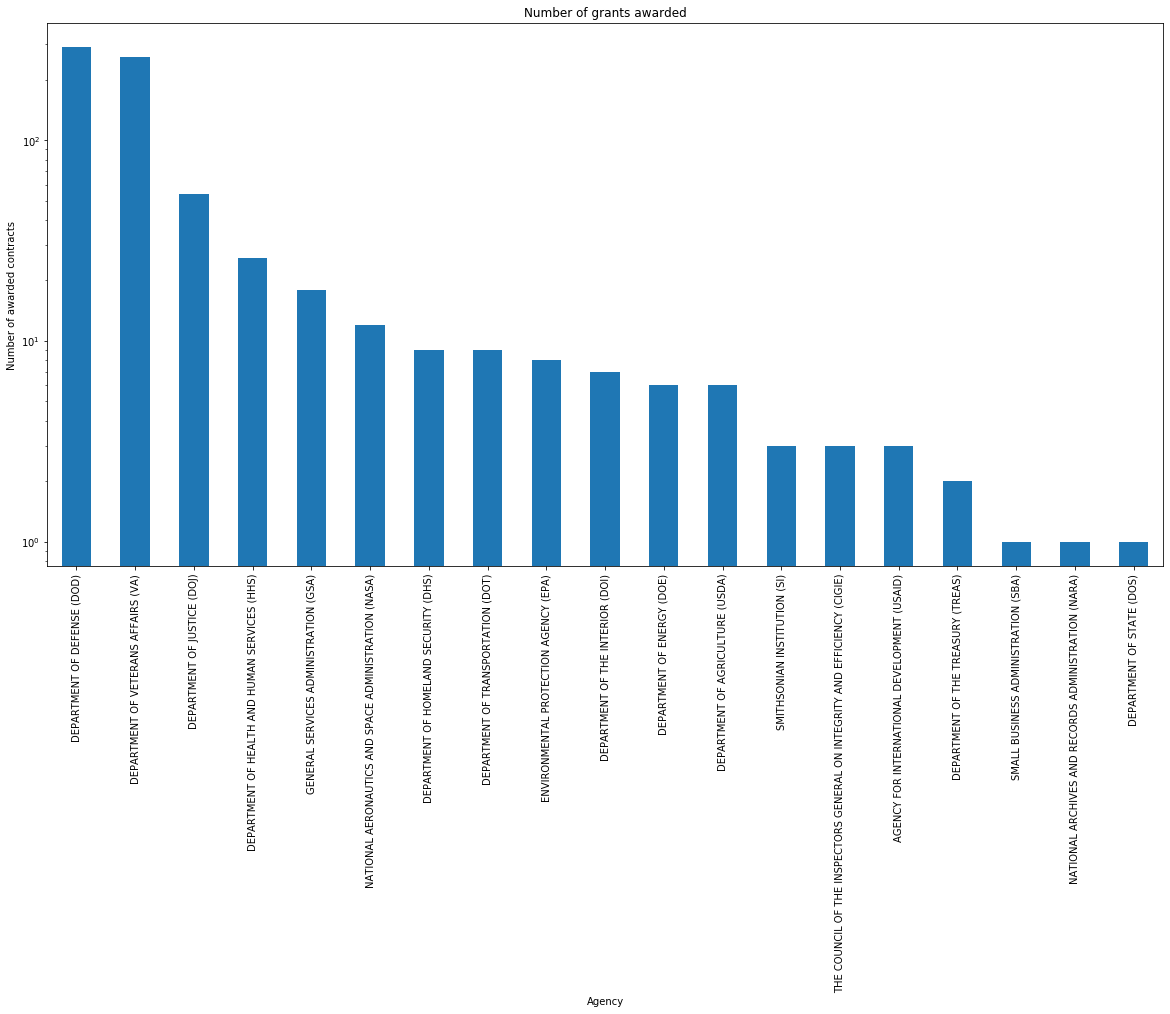

In [4]:
#Number of grants awarded by each agency

print('Agencies that awarded the most contracts:\n',unidat.funding_agency_name.value_counts().head())

ax=unidat.funding_agency_name.value_counts().plot(kind='bar', rot=90, logy=True, title='Number of grants awarded', figsize=(20,10))
ax.set_ylabel("Number of awarded contracts")
ax.set_xlabel("Agency")
plt.show()


### Amounts awarded by each agency
What do the two different indicators mean? They have some degree of correlation. Total dollars obligated seems more reasonable, since it is non negative.

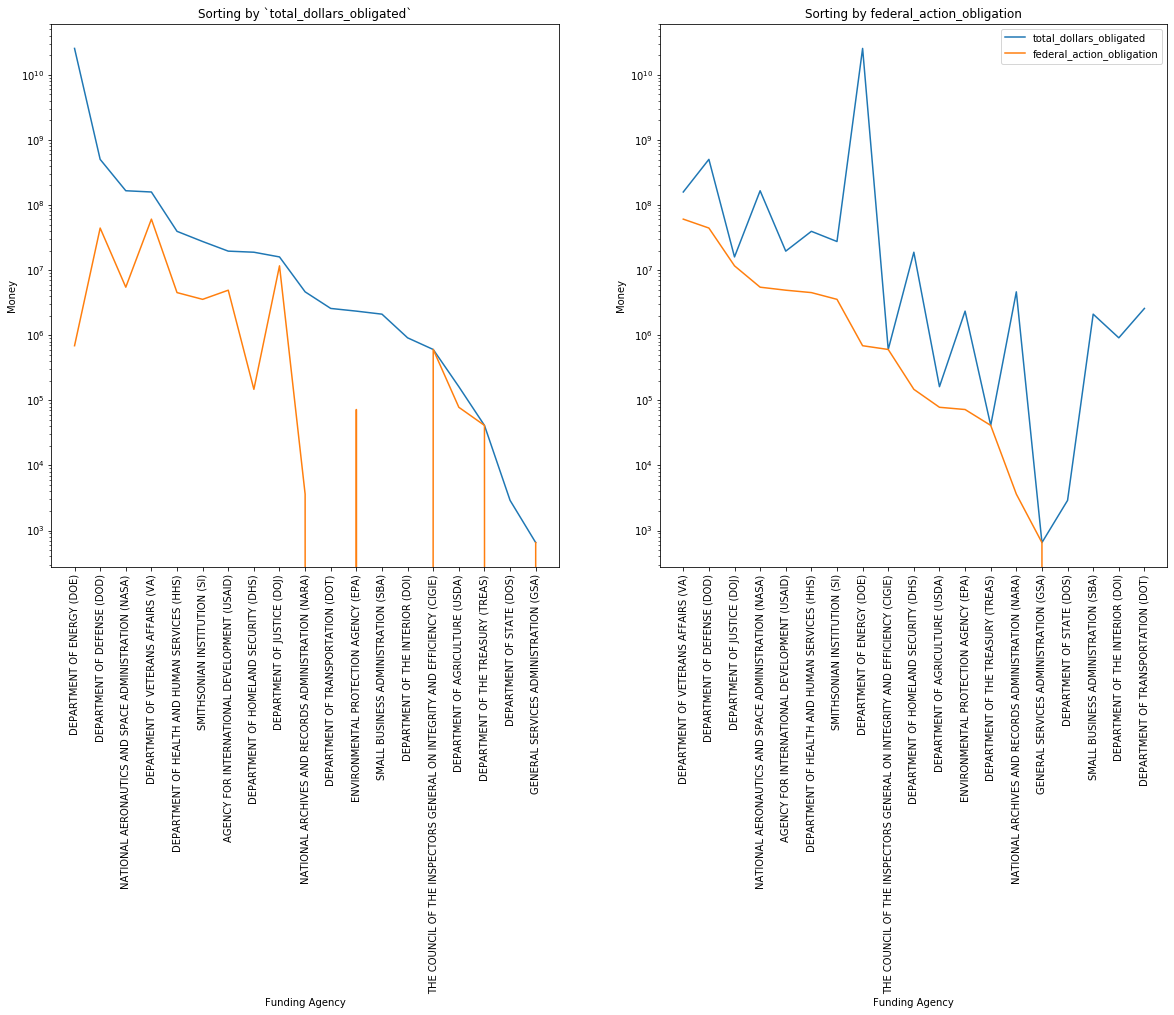

In [5]:
# Amount of money awarded by each agency
# Two columns that could be the total money: total_dollars_obligated and federal_action_obligation

agencies=unidat.funding_agency_name.unique()
dollars=np.array([unidat[unidat.funding_agency_name == ag]['total_dollars_obligated'].sum() for ag in agencies])
actions=np.array([unidat[unidat.funding_agency_name == ag]['federal_action_obligation'].sum() for ag in agencies])

# Sort dollars and agencies from poorest to richest
isort_actions=np.argsort(-actions) # The - is to invert order
isort_dollars=np.argsort(-dollars) # The - is to invert order


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
plt.xticks(rotation= 90)
ax1.set_yscale('log')
ax1.set_xlabel("Funding Agency")
ax1.set_ylabel("Money")
ax1.set_title('Sorting by `total_dollars_obligated`')
ax1.plot([agencies[i] for i in isort_dollars], [dollars[i] for i in isort_dollars], label='total_dollars_obligated')
ax1.plot([agencies[i] for i in isort_dollars], [actions[i] for i in isort_dollars], label='federal_action_obligation')


ax2 = fig.add_subplot(1, 2, 2)
plt.xticks(rotation= 90)
ax2.set_yscale('log')
ax2.set_xlabel("Funding Agency")
ax2.set_ylabel("Money")
ax2.set_title('Sorting by federal_action_obligation')
ax2.plot([agencies[i] for i in isort_actions], [dollars[i] for i in isort_actions], label='total_dollars_obligated')
ax2.plot([agencies[i] for i in isort_actions], [actions[i] for i in isort_actions], label='federal_action_obligation')
plt.legend()
plt.show()


### Money of all DOD grants

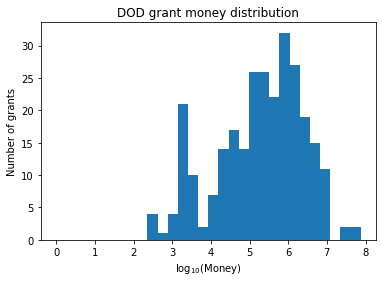

In [6]:
dod_funds = unidat[unidat.funding_agency_name == 'DEPARTMENT OF DEFENSE (DOD)']

# Linear Scale
# ax=dod_funds['total_dollars_obligated'].plot.hist(bins=50)
# ax.set_ylabel("Number of grants")
# ax.set_xlabel("Money")
# plt.show()


# Better to do logarithmic
logmoney=np.log10(dod_funds['total_dollars_obligated']+1e-9) # adding a small number to avoid log(0)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_ylabel("Number of grants")
ax.set_xlabel(r'$\log_{10}$(Money)')
ax.set_title('DOD grant money distribution')
ax.hist(logmoney, histtype='bar', bins=30, range=(0,logmoney.max()))
plt.show()


### Take a university, and show the distribution of fundings

Sources of contract funding of DUKE UNIVERSITY


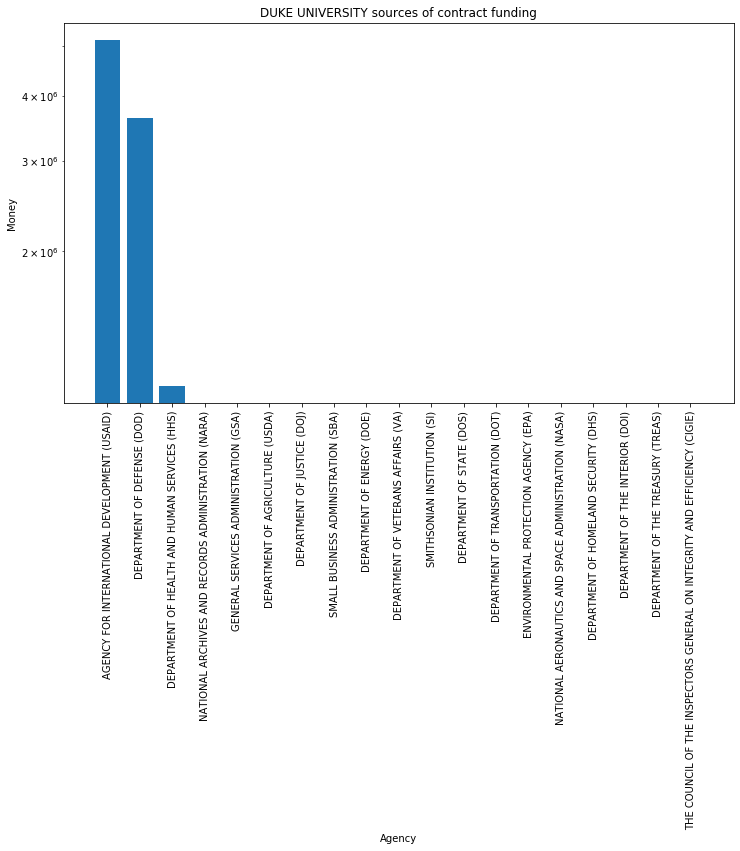

In [7]:
universities = unidat.recipient_name.unique()
uni=universities[0] # Just take one university from the list
print('Sources of contract funding of',uni)


uni_fundings = np.array([unidat[(unidat.recipient_name == uni) & (unidat.funding_agency_name == ag)].total_dollars_obligated.sum() for ag in agencies])
isort=np.argsort(-uni_fundings)


fig=plt.figure(figsize=(12,7))
ax=fig.add_subplot(111)
ax.bar([agencies[i] for i in isort],[uni_fundings[i] for i in isort])
ax.set_xlabel('Agency')
ax.set_ylabel('Money')
ax.set_yscale('log')
ax.set_title(uni+' sources of contract funding')
plt.xticks(rotation=90)
plt.show()

del isort # to avoid messes in other cells

### Rank institutions by their DOD funding 

In [8]:

uni_DOD_fundings = np.array([unidat[(unidat.recipient_name == uni) & (unidat.funding_agency_name == 'DEPARTMENT OF DEFENSE (DOD)')].total_dollars_obligated.sum() for uni in universities])
isort=np.argsort(-uni_DOD_fundings)

sorted_unis=np.array([universities[i] for i in isort])
sorted_fundings=np.array([uni_DOD_fundings[i] for i in isort])

del isort # to avoid messes in other cells

5 institutions that get the most money from the DOD
['CARNEGIE MELLON UNIVERSITY'
 'JOHNS HOPKINS UNIVERSITY APPLIED PHYSICS LABORATORY LLC, THE'
 'UNIVERSITY OF TEXAS AT AUSTIN' 'UNIVERSITY OF DAYTON'
 'UNIVERSITY OF ALABAMA IN HUNTSVILLE, THE'
 'PENNSYLVANIA STATE UNIVERSITY, THE']


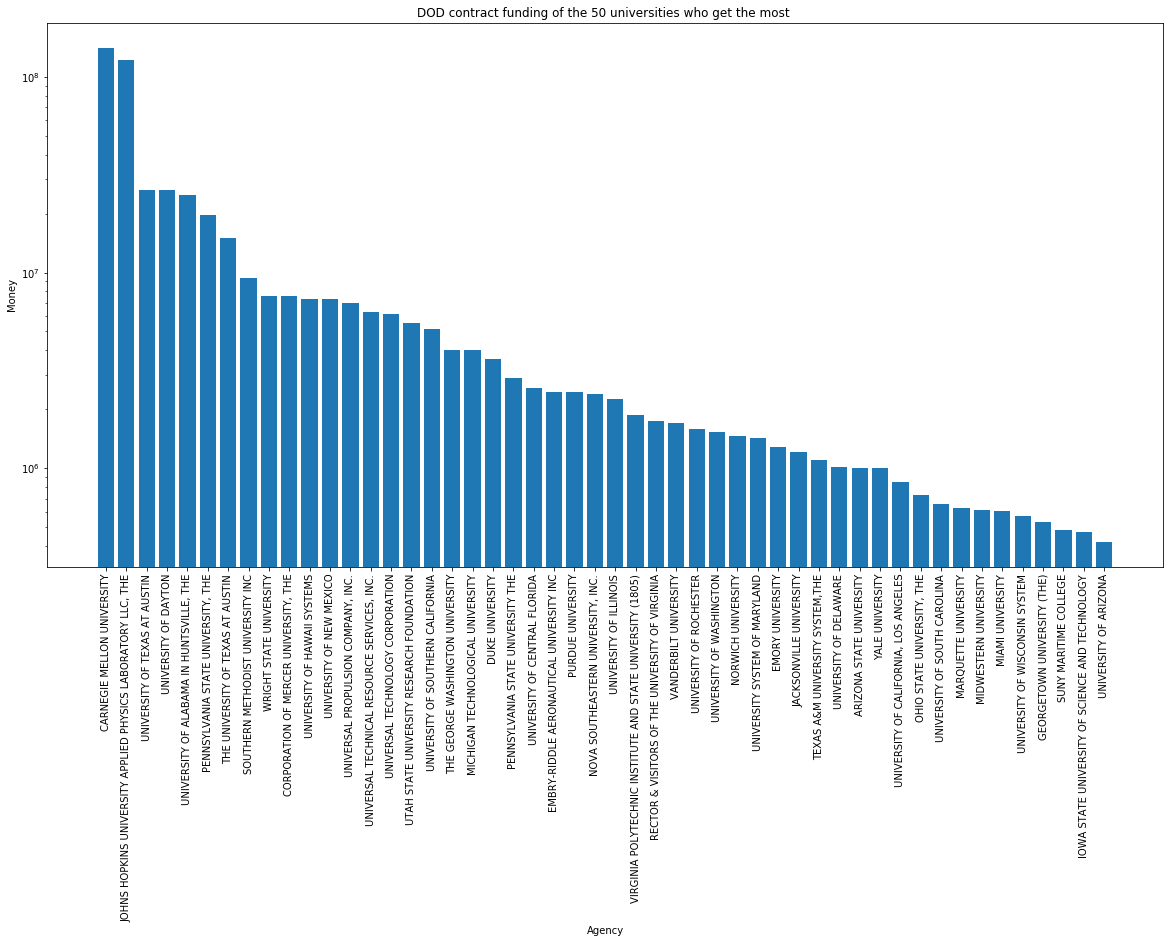

In [9]:
n=5
print(n,'institutions that get the most money from the DOD')
print(sorted_unis[:n+1])


cutoff=50
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.bar(sorted_unis[:cutoff],sorted_fundings[:cutoff])
ax.set_yscale('log')
ax.set_xlabel('Agency')
ax.set_ylabel('Money')
ax.set_title('DOD contract funding of the '+str(cutoff)+' universities who get the most ')
plt.xticks(rotation=90)
plt.show()
